In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

## Basis function

In [67]:
def identity_basis(x):
    ret = np.expand_dims(x, axis=1)
    return ret

def multinomial_basis(x, feature_num=10):
    x = np.expand_dims(x, axis=1) # shape(N, 1)
    ret = x.copy()
    for i in range(feature_num - 1):
        poly = np.power(x, i+2)
        ret = np.hstack((ret, poly))
    return ret

def gaussian_basis(x, feature_num=10, width_scale=1.0):
    x = np.expand_dims(x, axis=1)
    x_c = np.tile(x, (1, feature_num))
    mus = np.linspace(0, 25, feature_num)
    #mus = np.linspace(x.min(axis=0), x.max(axis=0), feature_num).reshape(-1)
    #sigma = (x.max(axis=0) - x.min(axis=0)) / 6
    sigma = width_scale * (mus[1] - mus[0])
    ret = np.exp(-0.5 * np.square((x_c - mus) / sigma))
    return ret

## Data Loading

In [68]:
def load_data(filename, basis_func=gaussian_basis):
    """载入数据。"""
    xys = []
    with open(filename, 'r') as f:
        for line in f:
            xys.append(map(float, line.strip().split()))
        xs, ys = zip(*xys)
        xs, ys = np.asarray(xs), np.asarray(ys)

        o_x, o_y = xs, ys
        phi0 = np.expand_dims(np.ones_like(xs), axis=1)
        phi1 = basis_func(xs)
        xs = np.concatenate([phi0, phi1], axis=1)
        return (np.float32(xs), np.float32(ys)), (o_x, o_y)

## Model, Criterion (Loss) & Optimizer

In [69]:
#in_feat_size = 1
#out_size = 1
#num_epochs = 6
#learning_rate = 1e-4

#model = nn.Linear(in_feat_size, out_size)
#criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training & Evaluation

In [110]:
def train(X, y, lr=1e-1, num_epochs=1000, batch_size=32, verbose=True, keep_loss=False):
    # data
    xs = torch.from_numpy(X)
    ys = torch.from_numpy(y)
    #ys = torch.unsqueeze(torch.from_numpy(y), 0)
    idx = np.arange(xs.shape[0])

    in_feat_size = xs.shape[1]
    out_size = 1

    # model
    model = nn.Linear(in_feat_size, out_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # train
    losses = []
    count = 0
    for epoch in range(num_epochs):
        np.random.shuffle(idx)
        batches = np.array_split(idx, xs.shape[0]//batch_size)
        for batch in batches:
            out = model(xs[batch])
            out = torch.squeeze(out, 1)
            loss = criterion(out, ys[batch])

            if keep_loss:
                losses.append(loss.item())
                count += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if verbose and (epoch+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}.')

    if keep_loss:
        losses = np.array(losses)

    return model, losses, count

In [111]:
def predict(model, X, y):
    y_pred = model(torch.from_numpy(X))
    out = y_pred.detach().numpy()
    criterion = nn.MSELoss()
    loss = criterion(torch.squeeze(y_pred, 1), torch.from_numpy(y))
    std = np.sqrt(loss.item())
    return out, std

Epoch 100/1000, Loss: 3.4044.
Epoch 200/1000, Loss: 3.0192.
Epoch 300/1000, Loss: 1.6592.
Epoch 400/1000, Loss: 1.9260.
Epoch 500/1000, Loss: 1.1643.
Epoch 600/1000, Loss: 1.0221.
Epoch 700/1000, Loss: 0.8328.
Epoch 800/1000, Loss: 0.8532.
Epoch 900/1000, Loss: 0.3918.
Epoch 1000/1000, Loss: 0.3242.


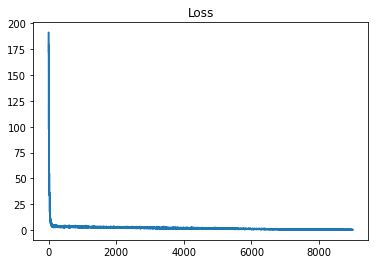

Standard Deviation of prediction from the real value in TRAINING set: 0.5991
Standard Deviation of prediction from the real value in TEST set: 0.7033


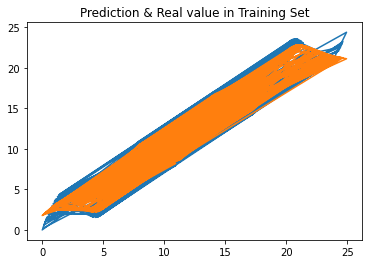

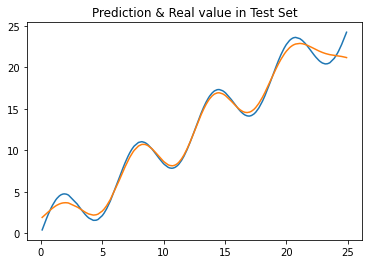

In [112]:
# load data
(xs, ys), (o_x, o_y) = load_data('train.txt')
(xs_test, ys_test), (o_x_test, o_y_test) = load_data('test.txt')

# train the model
model, losses, count = train(xs, ys, keep_loss=True)
plt.plot(np.arange(count)+1, losses)
plt.title('Loss')
plt.show()

# Evaluation
y_pred_train, std_train = predict(model, xs, ys)
y_pred_test, std_test = predict(model, xs_test, ys_test)

print(f'Standard Deviation of prediction from the real value in TRAINING set: {std_train:.4f}')
print(f'Standard Deviation of prediction from the real value in TEST set: {std_test:.4f}')

plt.plot(o_x, o_y)
plt.plot(o_x, y_pred_train)
plt.title('Prediction & Real value in Training Set')
plt.show()

plt.plot(o_x_test, o_y_test)
plt.plot(o_x_test, y_pred_test)
plt.title('Prediction & Real value in Test Set')
plt.show()
